In [ ]:
import os

import numpy as np
import pandas as pd
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

In [37]:
data_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/"
out_dir = os.path.join(data_dir, "derivatives", "nilearn_glm")

emotion_names = [
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
]

subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

n_subjects = len(subject_list)
n_emotions = len(emotion_names)

In [38]:
# === Step 1: Provide list of subject-level contrast maps ===
# # List all zmap nii.gz files for all emotions
zmap_files = []
for emotion in emotion_names:
    for subject in subject_list:
        zmap_files.append(os.path.join(out_dir, f"sub-{subject}_task-02a_stat-z_con-{emotion}.nii.gz"))

# Sort the zmap files
zmap_files.sort()

In [55]:
zmap_files

['/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-JoyfulActivation.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Nostalgia.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Peacefulness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Power.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Sadness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Tenderness.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Tension.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Transcendence.nii.gz',
 '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/sub-01_task-02a_stat-z_con-Wonder.nii.gz',
 '/Volumes/T7/B

In [39]:
len(zmap_files)

180

In [40]:
# === Step 2: Create design matrix ===

# Build long-format design info
rows = []
for subj in subject_list:
    for cond in emotion_names:
        rows.append({"subject_label": subj, "emotion": cond})

design_info = pd.DataFrame(rows)

# One-hot encode
dm = pd.get_dummies(design_info, columns=["emotion"], drop_first=False)
# Remove subject_label (not needed in X matrix)
dm_X = dm.drop(columns=["subject_label"])

In [41]:
dm_X

,emotion_JoyfulActivation,emotion_Nostalgia,emotion_Peacefulness,emotion_Power,emotion_Sadness,emotion_Tenderness,emotion_Tension,emotion_Transcendence,emotion_Wonder
0,True,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
175,False,False,False,False,True,False,False,False,False
176,False,False,False,False,False,True,False,False,False
177,False,False,False,False,False,False,True,False,False
178,False,False,False,False,False,False,False,True,False


In [42]:
# === Step 3: Fit the second-level model ===
second_level_model = SecondLevelModel(smoothing_fwhm=4)
second_level_model = second_level_model.fit(zmap_files, design_matrix=dm_X)


In [49]:
# === Step 4: Perform F-test across all emotion regressors ===

contrast_matrix = np.eye(len(emotion_names))  # F-test: one row per regressor

contrast_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
z_map = second_level_model.compute_contrast(second_level_contrast=contrast_matrix, second_level_stat_type="F", output_type="z_score")


In [58]:
f_map = second_level_model.compute_contrast(second_level_contrast=contrast_matrix, second_level_stat_type="F", output_type="stat")

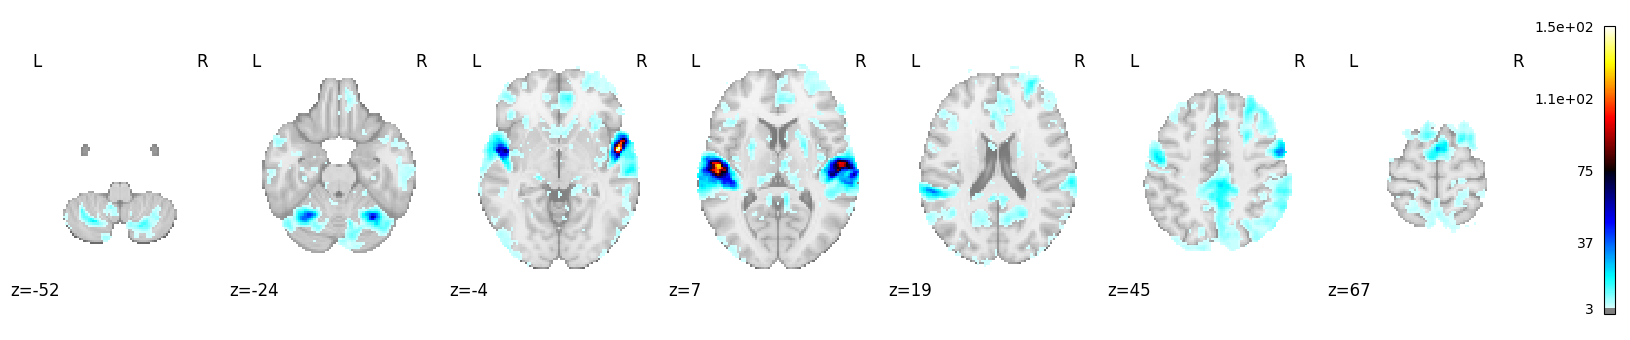

In [60]:
plot_stat_map(f_map, display_mode="z", cut_coords=7, colorbar=True, threshold=3)

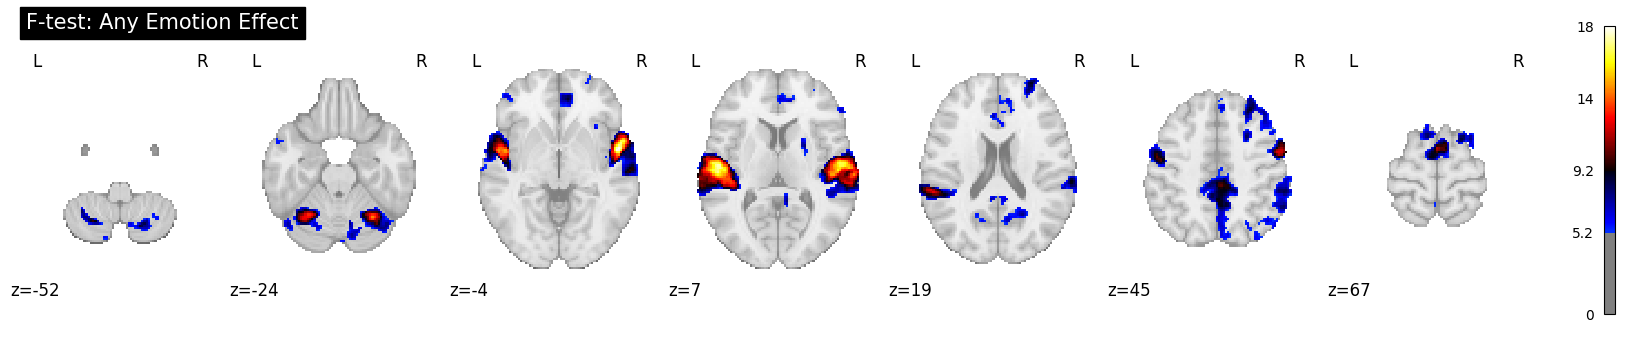

In [70]:
# === Step 5: Threshold the map and plot ===

thresholded_map, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="bonferroni", cluster_threshold=25)

plot_stat_map(thresholded_map, threshold=threshold, title="F-test: Any Emotion Effect", display_mode="z", cut_coords=7, colorbar=True)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



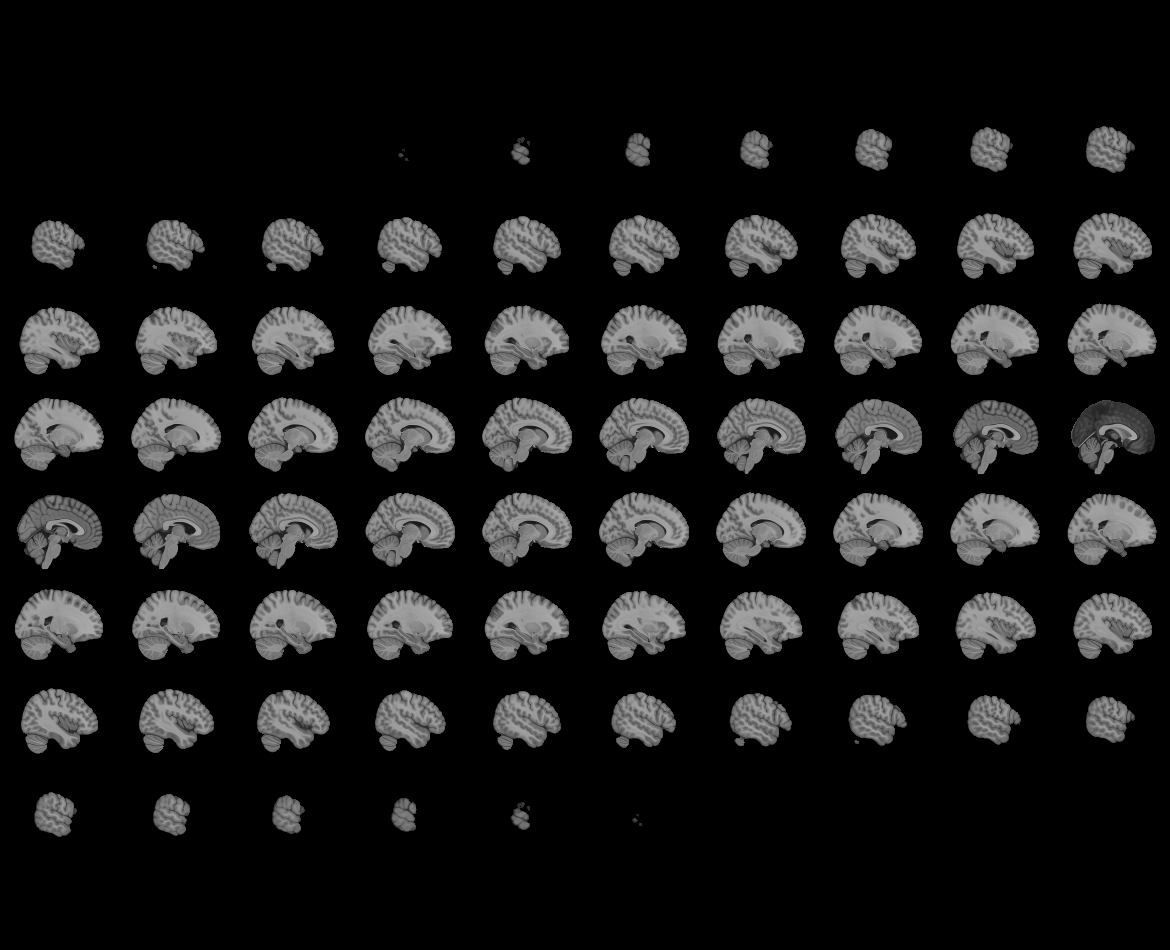
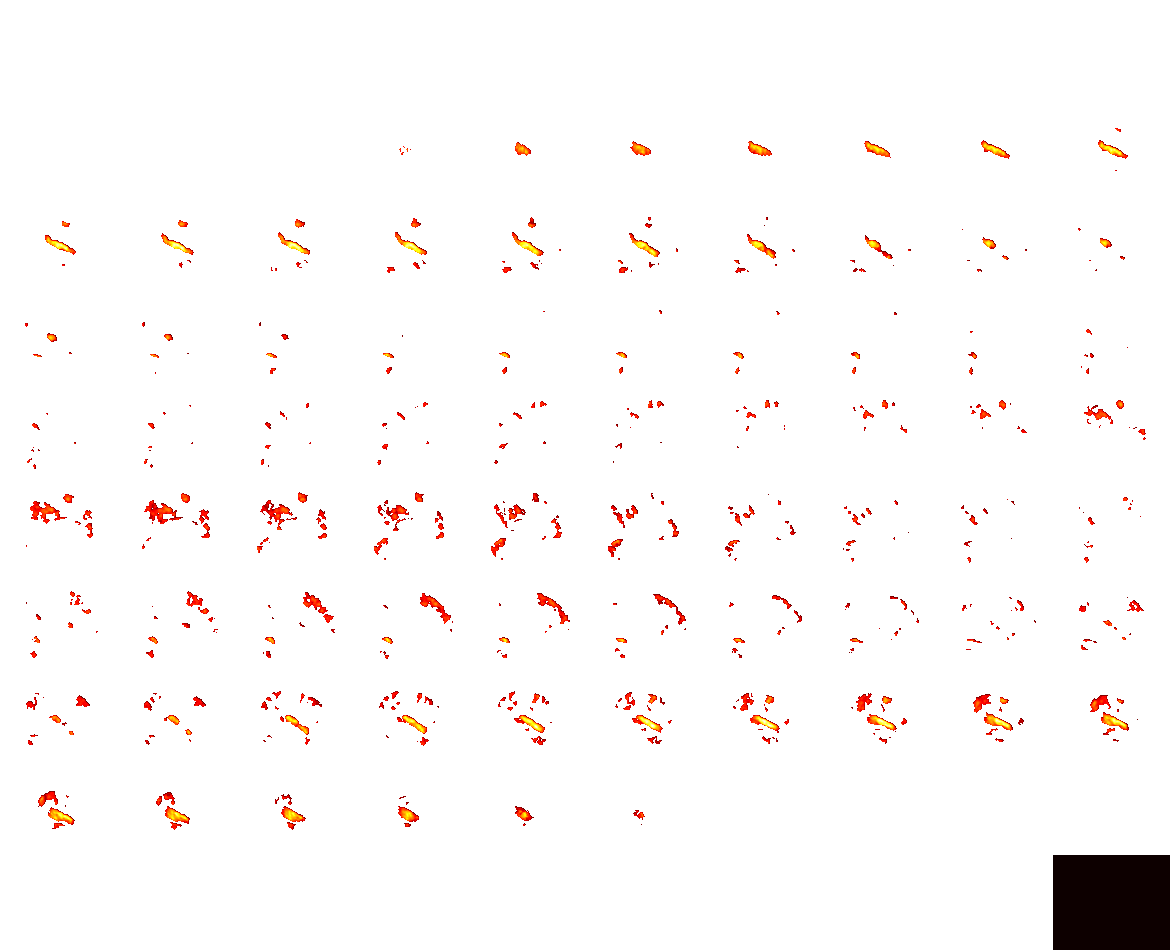

In [75]:
# | label: anova_2ndlevel_view_img
from nilearn.plotting import view_img

view_img(thresholded_map, threshold=threshold, title="F-test: Any Emotion Effect", colorbar=True)

In [ ]:
# | label: anova_2ndlevel_cluster_table
from mni_to_atlas import AtlasBrowser
from nilearn.reporting import get_clusters_table

atlas = AtlasBrowser("AAL3")

pd.set_option("display.max_rows", 120)

# Cluster table
table_sum, cluster_map_sum = get_clusters_table(thresholded_map, 0, 1, return_label_maps=True)

# AAL3 labelling
coordinates = table_sum[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_sum["AAL3"] = aal_labels

table_sum

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,53.5,1.5,-4.5,18.449056,24784,Temporal_Sup_R
1,1a,53.5,-10.5,3.5,18.021674,,Heschl_R
2,1b,59.5,1.5,-0.5,16.451455,,Temporal_Pole_Sup_R
3,1c,63.5,-16.5,9.5,15.887092,,Temporal_Sup_R
4,2,-52.5,-14.5,5.5,17.823405,25664,Temporal_Sup_L
5,2a,-56.5,-4.5,-0.5,17.740359,,Temporal_Sup_L
6,2b,-54.5,-20.5,7.5,17.493439,,Temporal_Sup_L
7,2c,-46.5,-26.5,11.5,15.179522,,Temporal_Sup_L
8,3,29.5,-60.5,-24.5,14.406896,7888,Cerebellum_6_R
9,3a,11.5,-68.5,-14.5,11.100923,,Cerebellum_6_R
